In [4]:
# imports 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
import matplotlib.pyplot as plt

import numpy as np
from math import pi

from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

sim = AerSimulator()

# Lab 2 – From Classical Boolean Functions to Quantum Oracles

---
In **Lab 1** we learnt how to *manipulate* quantum states: we built circuits with
single-qubit gates (X, H, S, T, Z), used two-qubit gates (CNOT, CZ) to create
entanglement (Bell states), and started to see how quantum states live in a much
richer space than classical states made out of bits.

In this lab we want to take the next step towards **quantum algorithms**:
we need a way to encode *classical problems* inside quantum circuits so that
quantum mechanics can work on them.

### Lab objectives

1.  **Show that a quantum computer can reproduce any classical logic.**
    We will build reversible versions of the basic gates `NOT`, `FANOUT`, `AND` and `OR` using X, CNOT and Toffoli quantum gates, plus a few ancilla qubits. This matters for two reasons:
    * It tells us that quantum computers are at least as powerful as classical ones: *any* Boolean function $f:\{0,1\}^n \to \{0,1\}^m$ that a classical circuit can compute can also be implemented as a unitary $U_f$ on a quantum computer (the converse is not true because classical hardware cannot create superposition or entanglement).
    * It gives us a systematic way to cook up the **building blocks** we need for algorithms: functions that answer questions like "does this bit string open the safe?" or "does this proposed schedule obey all the constraints?". Once such a predicate is written as a classical Boolean circuit, we know how to convert it into a reversible quantum circuit.

2.  **Formalise classical logic as quantum oracles.**
    We will package these reversible circuits into a "black box" unitary
    $U_f$ that maps $|x\rangle|y\rangle \mapsto |x\rangle|y \oplus f(x)\rangle$.
    This is the standard query model used in many quantum algorithms.

3.  **Explore phase kickback.**
    By feeding superposition states into the ancilla of $U_f$, we will see how
    the value of $f(x)$ can be encoded as a *phase* $(-1)^{f(x)}$, a purely
    quantum effect called **phase kickback**.

4.  **Build Deutsch’s algorithm.**
    Finally, we will combine these ideas into our first full quantum algorithm,
    which distinguishes between two types of functions with fewer evaluations
    than any classical strategy.

---

## 1. Classical Gates as Quantum Gates

### 1.1 Implementing the Classical NOT Gate

To demonstrate that a quantum computer can perform classical computations, we must show how to build the most basic classical logic. The primary challenge is that all quantum operations (bar measurement) must be **reversible**.

The simplest classical operation is the **NOT** gate, which flips a bit:
* $NOT(0) \rightarrow 1$
* $NOT(1) \rightarrow 0$

This operation is already reversible (applying NOT twice gets you back to the start). Its quantum implementation is the **X gate**, which is a unitary matrix and its own inverse ($X^2 = I$). It performs the identical operation on the computational basis states:
* $X|0\rangle = |1\rangle$
* $X|1\rangle = |0\rangle$

In [ ]:
def demo_not():
    """Implements NOT(0)"""
    # TODO: create a circuit with 1 qubit (q0), 1 classical bit (c0)
    ... # FILL IN
    
    # TODO: Apply X gate to q0. The state |0> becomes |1>.
    ... # FILL IN
    
    # Measure q0 into c0. We expect to measure '1'.
    ... # FILL IN
    
    return qc

not_qc = demo_not()
print("Circuit for NOT(0):")
display(not_qc.draw("mpl"))

# Run the simulation. We expect 100% '1's.
print("Result:")
print(sim.run(not_qc, shots=1024).result().get_counts())

### 1.2 Implementing the Classical FANOUT (Copy) Operation

A more complex classical operation is **FANOUT**, or copying. Classically, we just split a wire: $a \mapsto (a, a)$.

**The Quantum Challenge:**
This is not a simple gate. We cannot "clone" an arbitrary quantum state (due to the [**No-Cloning Theorem**](https://en.wikipedia.org/wiki/No-cloning_theorem)). Furthermore, a simple $1 \rightarrow 2$ wire split is not reversible.

**Quantum Implementation:**
We *can*, however, build a **reversible quantum circuit** that copies a *classical basis state* ($|0\rangle$ or $|1\rangle$). The tool for this is the **CNOT gate** and an **ancilla qubit** (a "helper" qubit, as seen before).

**Procedure for a Reversible FANOUT:**
1.  We need two qubits: an **input qubit** (let's use `q0`) and an **ancilla qubit** (let's use `q1`).
2.  We initialise the ancilla to $|0\rangle$. The total state is $|q_1, q_0\rangle = |0, a\rangle$.
3.  We apply a CNOT gate with the **input (`q0`) as the control** and the **ancilla (`q1`) as the target**.
4.  The CNOT's rule is $|q_1, q_0\rangle \mapsto |q_1 \oplus q_0, q_0\rangle$.
5.  Let's trace the two possible cases for our classical input:
    * **Input $a=0$**: State is $|0, 0\rangle$. CNOT does nothing. Final state is $|0, 0\rangle \rightarrow |a, a\rangle$.
    * **Input $a=1$**: State is $|0, 1\rangle$. CNOT control (`q0`) is 1, so it flips the target (`q1`). Final state is $|1, 1\rangle \rightarrow |a, a\rangle$.

In both cases, we successfully map $|0, a\rangle \mapsto |a, a\rangle$, implementing a reversible FANOUT.

Circuit for FANOUT(1):


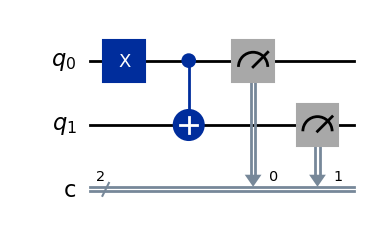

Result:
{'11': 1024}


In [8]:
def demo_fanout_of_1():
    """Implements FANOUT(1) using CNOT"""
    # q0 is the input bit 'a'
    # q1 is the ancilla bit, initialised to 0
    qc = QuantumCircuit(2, 2)
    
    # Prepare the input state |a=1>.
    qc.x(0)  # State is |01> (q1=0, q0=1)
    
    # Apply CNOT(control=q0, target=q1).
    # Since q0=1, q1 flips from 0 to 1.
    # The final state is |11> (q1=1, q0=1), which is |a, a>.
    qc.cx(0, 1)
    
    # Measure both qubits
    qc.measure([0, 1], [0, 1])
    return qc
# --- END SOLUTION ---

fanout_qc = demo_fanout_of_1()
print("Circuit for FANOUT(1):")
display(fanout_qc.draw("mpl"))

# Run the simulation. We expect 100% '11's.
print("Result:")
print(sim.run(fanout_qc, shots=1024).result().get_counts())

### 1.3 Implementing the Classical AND Gate

* **Classical Operation:** The AND gate takes two input bits, $a$ and $b$, and outputs $1$ if and only if both $a=1$ AND $b=1$.
* **Quantum Implementation:** This operation is not reversible by itself (e.g., an output of $0$ could come from $00, 01,$ or $10$). To build it, we need a 3-qubit gate called the **Toffoli** (or **CCX** / Controlled-Controlled-NOT) gate.

**Procedure:**
We use three qubits: two for our inputs, $|a\rangle$ and $|b\rangle$, and a third **ancilla** qubit initialised to $|0\rangle$.

The Toffoli gate uses $|a\rangle$ and $|b\rangle$ as **controls** and the ancilla as the **target**. It flips the target *if and only if* both controls are 1.

Let's trace the operation $|a, b, 0\rangle \mapsto |a, b, 0 \oplus (a \land b)\rangle$:
* $|0, 0, 0\rangle \rightarrow |0, 0, 0 \oplus (0 \land 0)\rangle = |0, 0, 0\rangle$
* $|0, 1, 0\rangle \rightarrow |0, 1, 0 \oplus (0 \land 1)\rangle = |0, 1, 0\rangle$
* $|1, 0, 0\rangle \rightarrow |1, 0, 0 \oplus (1 \land 0)\rangle = |1, 0, 0\rangle$
* $|1, 1, 0\rangle \rightarrow |1, 1, 0 \oplus (1 \land 1)\rangle = |1, 1, 1\rangle$

The ancilla qubit (the last one) now holds the result of $a \text{ AND } b$, and the original inputs are preserved, making the operation reversible.


Input a=0, b=0


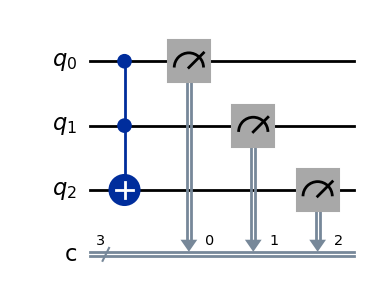

Measurement counts: {'000': 1024}


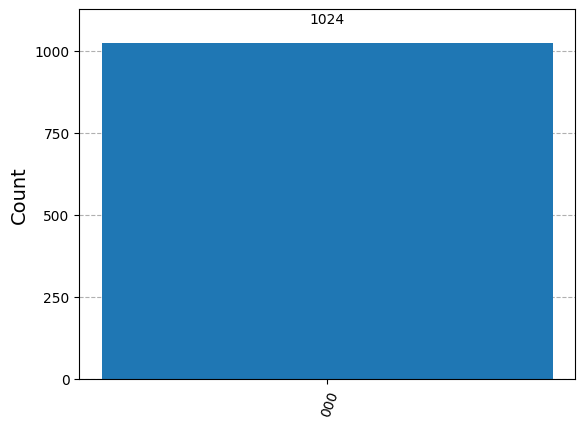


Input a=0, b=1


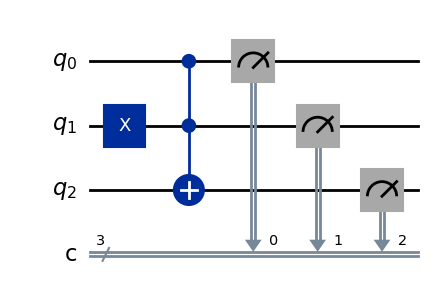

Measurement counts: {'010': 1024}


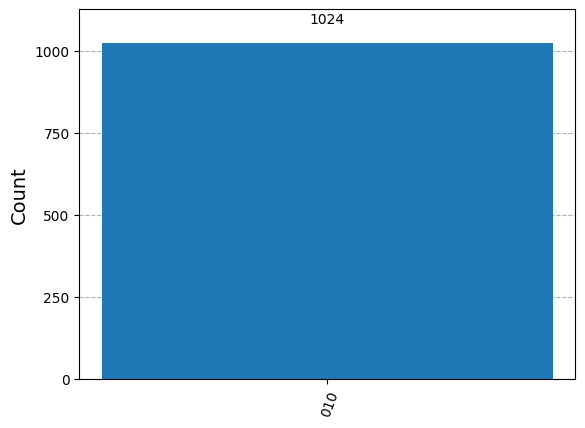


Input a=1, b=0


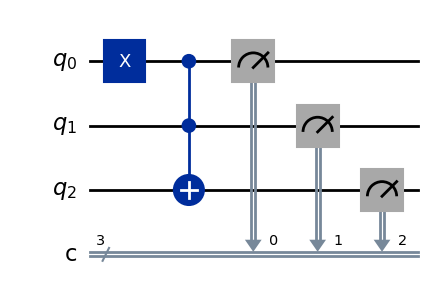

Measurement counts: {'001': 1024}


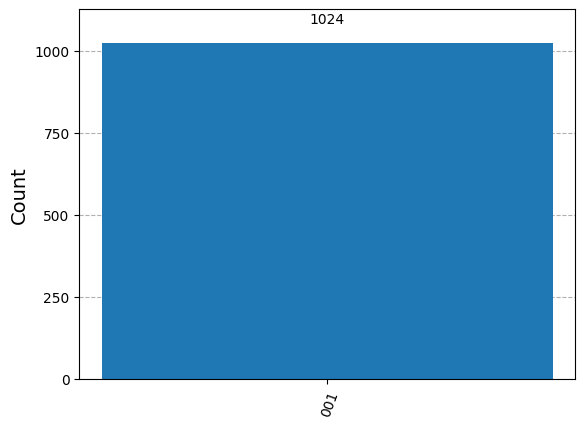


Input a=1, b=1


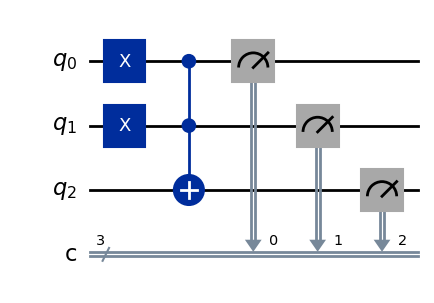

Measurement counts: {'111': 1024}


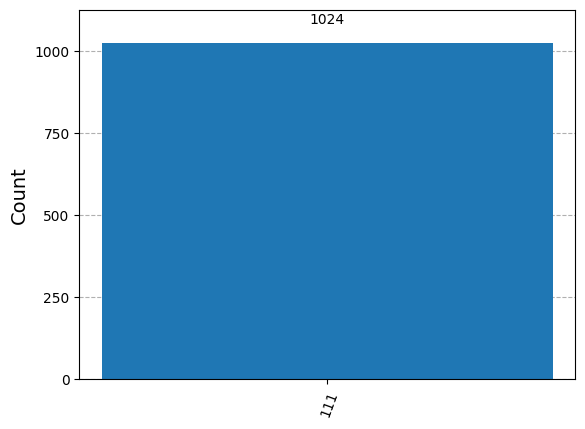

In [11]:
def run_and_demo(a: int, b: int):
    """Prepare |a,b,0>, apply CCX, measure, and print the result."""
    qc = QuantumCircuit(3, 3)

    # Prepare inputs a,b
    if a == 1:
        qc.x(0)   # set q0 = 1
    if b == 1:
        qc.x(1)   # set q1 = 1

    # Toffoli: ancilla q2 flips iff q0=1 AND q1=1
    qc.ccx(0, 1, 2)

    # Measure all qubits (classical bits ordered [c0,c1,c2])
    qc.measure([0, 1, 2], [0, 1, 2])

    print(f"\nInput a={a}, b={b}")
    display(qc.draw("mpl"))

    result = sim.run(qc, shots=1024).result()
    counts = result.get_counts()
    print("Measurement counts:", counts)
    display(plot_histogram(counts))

# Run the demo for all four input combinations
for a in [0, 1]:
    for b in [0, 1]:
        run_and_demo(a, b)

### 1.4 Implementing the Classical OR Gate

* **Classical Operation:** The OR gate outputs 1 if $a=1$ *or* $b=1$.
* **Quantum Implementation:** There is no single elementary "OR" gate. We must construct it using the gates we already have. The standard method uses the **Toffoli** gate and **De Morgan's Law**:

$$
a \lor b = \neg(\neg a \land \neg b)
$$
(Read as: "A or B" is the same as "NOT (NOT A AND NOT B)")

**Procedure:**
We follow the logic of De Morgan's Law step-by-step:
1.  **Start:** $|a, b, 0\rangle$
2.  **Apply X to inputs:** Negate $a$ and $b$. State becomes $|\neg a, \neg b, 0\rangle$.
3.  **Apply Toffoli:** Compute the AND of the negated inputs into the ancilla. State becomes $|\neg a, \neg b, (\neg a \land \neg b)\rangle$.
4.  **Apply X to ancilla:** Negate the result. The ancilla now holds $\neg(\neg a \land \neg b)$, which is $a \lor b$. State is $|\neg a, \neg b, a \lor b\rangle$.
5.  **"Uncompute" Inputs:** Apply X to the inputs again to restore them. The final state is $|a, b, a \lor b\rangle$.


Input a=0, b=0


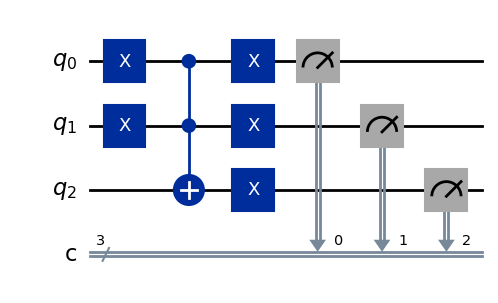

Measurement counts: {'000': 1024}


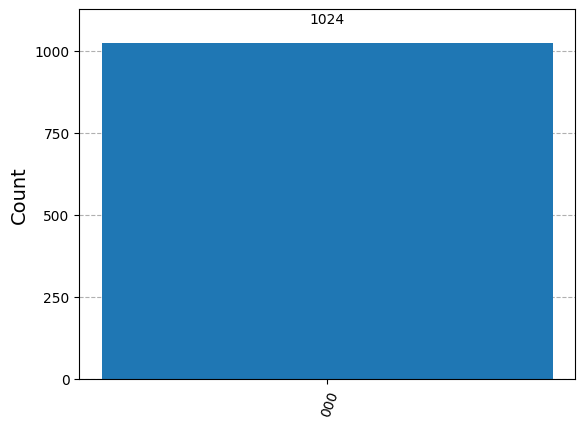


Input a=0, b=1


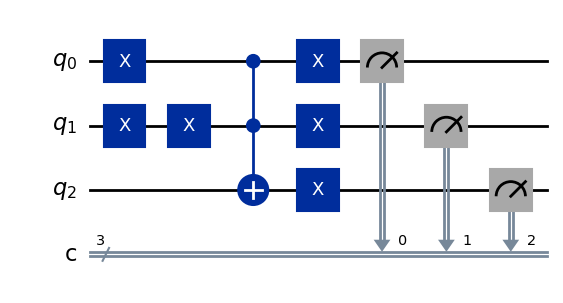

Measurement counts: {'110': 1024}


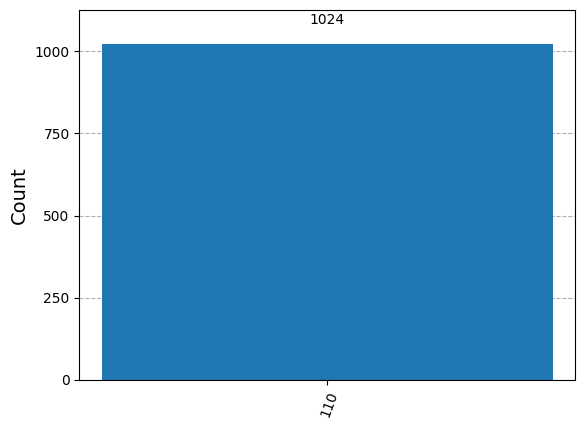


Input a=1, b=0


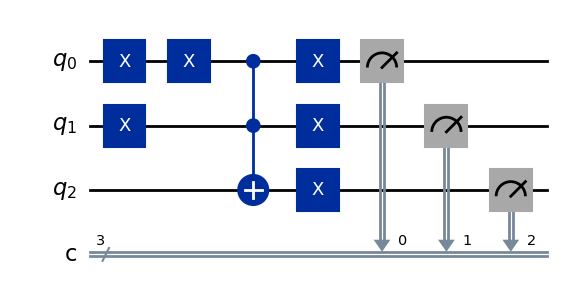

Measurement counts: {'101': 1024}


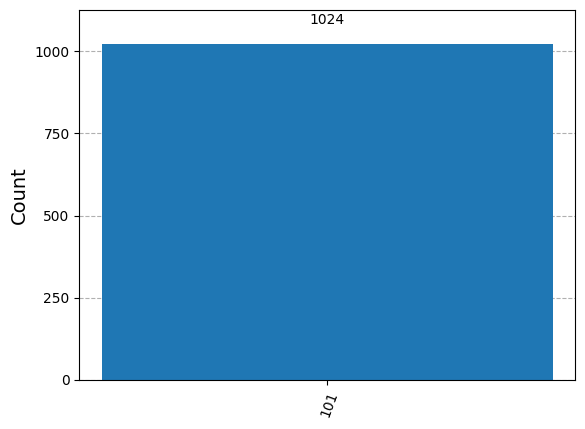


Input a=1, b=1


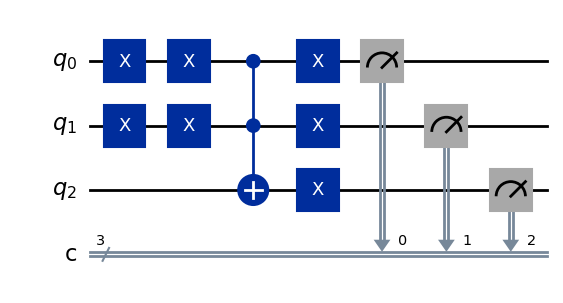

Measurement counts: {'111': 1024}


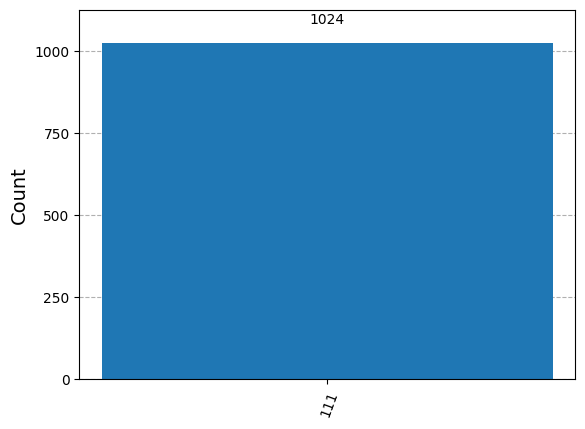

In [12]:
def run_or_demo(a: int, b: int):
    """Prepare |a,b,0>, implement OR via X+CCX+X, measure, and print result."""
    qc = QuantumCircuit(3, 3)

    # Prepare inputs a,b
    if a == 1:
        qc.x(0)   # q0 = a
    if b == 1:
        qc.x(1)   # q1 = b

    # --- OR implementation on ancilla q2 ---
    # 1) negate inputs: a -> ¬a, b -> ¬b
    qc.x(0)
    qc.x(1)
    # 2) Toffoli: ancilla <- (¬a AND ¬b)
    qc.ccx(0, 1, 2)
    # 3) negate ancilla: ancilla <- NOT(¬a AND ¬b) = a OR b
    qc.x(2)
    # 4) restore inputs
    qc.x(0)
    qc.x(1)
    # -----------------------------

    qc.measure([0, 1, 2], [0, 1, 2])

    print(f"\nInput a={a}, b={b}")
    display(qc.draw("mpl"))

    result = sim.run(qc, shots=1024).result()
    counts = result.get_counts()
    print("Measurement counts:", counts)
    display(plot_histogram(counts))

# Run the demo for all four input combinations
for a in [0, 1]:
    for b in [0, 1]:
        run_or_demo(a, b)

### 1.5 Summary: From Classical Gates to Quantum Oracles

We have now seen explicit quantum realisations of the basic classical gates:

* **NOT** → single-qubit X gate.
* **FANOUT** → CNOT (with an ancilla initialised to $|0\rangle$).
* **AND** → Toffoli (CCX) (with an ancilla initialised to $|0\rangle$).
* **OR** → A circuit built from X and Toffoli gates.

These examples prove a general fact: **any classical computation can be carried out on a quantum computer**. We do this by replacing each classical gate with its reversible quantum counterpart, adding ancilla qubits as needed to preserve reversibility.

In the language of quantum algorithms, we call such a reversible circuit $U_f$ (which computes a function $f(x)$) a **query** or an **oracle**.

---

## 2. From Classical Boolean Functions to Quantum Oracles

In the previous section we learnt how to realise the basic classical gates
(**NOT**, **FANOUT**, **AND**, **OR**) as reversible quantum circuits using X,
CNOT and Toffoli gates, together with a few ancilla qubits.

We now package these building blocks into a single object that the theory of 
computation calls a **query oracle**.

The starting point is a classical Boolean function from $n$ to $m$ bits:
$$
f : \{0,1\}^n \rightarrow \{0,1\}^m.
$$
Think of $f$ as the logic for a real decision task; for instance:

* “Does this bit string open the safe?”
* “Is this proposed timetable conflict–free?”
* “Does this configuration satisfy all the puzzle rules?”

Classically we would implement $f$ as a circuit built from AND / OR / NOT /
FANOUT (and ancillas). Since we know how to make *each* of these gates reversible, we can replace
every classical gate by its quantum counterpart and obtain a reversible
quantum circuit that computes the **same** function.

### 2.1 General Query Oracle $U_f$

The reversible circuit for $f$ will act on two registers:

* an input/query register $|x\rangle$ of $n$ qubits, and
* an output/target/workspace register of $k$ qubits (at least $m$ to hold the
  answer, plus any ancillas we may need internally).

We write the corresponding unitary as $U_f$. In other words, $U_f$ is the quantum (reversible) version of the classical circuit that implements the Boolean function $f$. Its behaviour is defined as
$$
U_f : |x\rangle\,|0^{k}\rangle \longmapsto |x\rangle\,|f(x)\rangle\,|\text{(workspace)}\rangle,
$$
where we will not worry about the exact final state of the extra workspace
qubits. The important point is:

> For every classical circuit computing $f$ there exists a reversible
> quantum circuit $U_f$ implementing the same input–output relation.

This tells us that a quantum computer can reproduce **any** classical
computation; classical hardware, however, cannot simulate all quantum
operations because it has no access to superposition or entanglement.

### 2.2 Boolean Functions and the Standard Oracle Form

For the algorithms in this lab we focus on a particularly convenient special
case: **Boolean functions**
$$
f : \{0,1\}^n \rightarrow \{0,1\},
$$
where the output is a single bit $(m-1)$.

Instead of starting the output qubit in $|0\rangle$ and overwriting it, we
use a slightly more flexible reversible form often called the **query oracle**
or **black–box oracle**:

$$
U_f : |x\rangle|y\rangle \longmapsto |x\rangle\,|y \oplus f(x)\rangle,
$$
where $\oplus$ is XOR (addition modulo 2).

The input register $|x\rangle$ is returned unchanged, while the second
register is updated by “adding” $f(x)$. Because XOR is reversible, this
definition automatically gives us a unitary operation.

Below we build a concrete example of such an oracle.

#### 2.2 Example: Oracle for a 3-bit parity function

To make things a bit more interesting, let us build an oracle for the **parity**
function on three input bits

$$
f(x_0,x_1,x_2) = x_0 \oplus x_1 \oplus x_2,
$$

which outputs 1 iff an **odd** number of the inputs are 1. The truth table is:

$$
\begin{array}{c|c}
(x_0 x_1 x_2) & f(x_0,x_1,x_2) \\
\hline
000 & 0\\
001 & 1\\
010 & 1\\
011 & 0\\
100 & 1\\
101 & 0\\
110 & 0\\
111 & 1\\
\end{array}
$$

We use three input qubits $q_0,q_1,q_2$ and one output qubit $q_3$ that plays
the role of $y$. The oracle must implement

$$
U_f : |x_0 x_1 x_2\rangle|y\rangle
      \longmapsto
      |x_0 x_1 x_2\rangle\,|y \oplus (x_0 \oplus x_1 \oplus x_2)\rangle .
$$

A simple way to achieve this is to apply a CNOT from **each** input qubit to
the output qubit. Each CNOT performs $y \mapsto y \oplus x_i$, so three CNOTs
in a row give $y \mapsto y \oplus x_0 \oplus x_1 \oplus x_2$.

In [ ]:
# Oracle Uf for f(x0, x1, x2) = x0 XOR x1 XOR x2 (3-bit parity)

def oracle_parity_gate():
    """
    Oracle Uf for the Boolean parity function:
        f(x0, x1, x2) = x0 XOR x1 XOR x2.

    Qubits (Qiskit little-endian):
      q0, q1, q2 : input bits
      q3         : output bit y

    Implements:
      |x0, x1, x2, y>  ->  |x0, x1, x2, y XOR f(x0,x1,x2)>
    """
    qc = QuantumCircuit(4, name="Uf_parity_internal")

    # TODO for students:

    # Wrap the whole circuit as a single oracle gate labelled U_f
    Uf = qc.to_gate(label=r"$U_f$")
    Uf.name = "Uf"   # short ASCII label in text diagrams
    return Uf

# Build the oracle gate once
Uf_parity = oracle_parity_gate()

# To *draw* it, we must place the gate inside a circuit:
qc_show = QuantumCircuit(4)
qc_show.append(Uf_parity, [0, 1, 2, 3])

display(qc_show.draw("mpl", scale=1.4))   # scale optional, just for width


In [20]:
# Probing the oracle in superposition and viewing the state in LaTeX

def show_parity_oracle_state():
    """
    Prepare |+++0>, apply Uf_parity, and display the resulting statevector.

    After Uf_parity we should obtain:
        (1/sqrt{8}) sum_x |x, f(x)>
    where the first qubit (q3 in little-endian) equals the parity of (x0,x1,x2).
    """
    qc = QuantumCircuit(4)

    # Put the three input bits into a uniform superposition over {0,1}^3
    qc.h([0, 1, 2])     # creates |+++>
    # Output qubit q3 starts in |0>

    # Apply the oracle gate (no .to_gate() here, it's already a Gate)
    qc.append(Uf_parity, [0, 1, 2, 3])

    # Get the statevector and display it nicely
    sv = Statevector.from_instruction(qc)
    display(sv.draw("latex"))

show_parity_oracle_state()


<IPython.core.display.Latex object>

**Qubit order reminder (Qiskit little-endian).**
Qiskit prints basis states as $|q_3 q_2 q_1 q_0\rangle$.
In our convention for the parity oracle this means
$$
|q_3 q_2 q_1 q_0\rangle = |y\,x_0\,x_1\,x_2\rangle
$$
so the **first** bit you see in the LaTeX output is the oracle output $y$, followed by the inputs $x_0,x_1,x_2$.

## 3. Deutsch’s Algorithm and Phase Kickback

We will now use the ideas reviewed in this lab to study our **first quantum algorithm** — *Deutsch’s algorithm*.
The new ingredient is a purely quantum effect called **phase kickback**, which is exactly the mechanism that later gives Grover’s algorithm its famous factor $(-1)^{f(x)}$.

### 3.1 Deutsch’s Problem (Statement)

We are given black-box access to a Boolean function from one to one bits

$$
f:\{0,1\} \to \{0,1\}.
$$

There are only four possible functions of this type, which we can summarise in a truth table. The inputs are on the top row, and the outputs for each function are on the rows below:

$$
\begin{array}{c|c|c|c}
\textbf{Function} & \textbf{Input } x=0 & \textbf{Input } x=1 & \textbf{Type} \\
\hline
f_1(x) & 0 & 0 & \textbf{Constant} \\
f_2(x) & 0 & 1 & \textbf{Balanced} \\
f_3(x) & 1 & 0 & \textbf{Balanced} \\
f_4(x) & 1 & 1 & \textbf{Constant}
\end{array}
$$

* $f_1$ and $f_4$ are **constant** (the output is the same for all inputs).
* $f_2$ and $f_3$ are **balanced** (the output is 0 for half the inputs and 1 for the other half).

> **Deutsch’s Problem.**
> 
> Input: a black-box function $f$ (which is one of the four above).
> 
> Output: decide whether $f$ is **constant** or **balanced**.

Classically, to solve this, you must check $f(0)$ **and** $f(1)$ to see if they are the same. This requires **two** queries to the function.
Deutsch’s algorithm does better: it solves the problem with **one single query** to the quantum oracle $U_f$.

---
**A Note on the speed-up:**

Solving this problem in one query instead of two is a 100% speed-up, but it doesn't change the world. The true power of this idea is that it **scales**; that is, an even bigger effect is seen if the number of bits in $f$ is increased.

This simple algorithm is the foundation for the **Deutsch-Jozsa algorithm**. We will see later that this scaled-up version solves the same problem for functions with *n* input bits, $f:\{0,1\}^n \to \{0,1\}$, still in **one single query**. In contrast, the best classical method would require up to $2^{n-1} + 1$ queries to be certain. *That* is an exponential speed-up and provides in principle a real quantum advantage.

---

### 3.2 Building 1-bit Query Oracles in Qiskit

We reuse exactly the oracle structure from Part 2:

$$
U_f:\;|x\rangle|y\rangle \longmapsto |x\rangle\,|y\oplus f(x)\rangle,
$$

where $\oplus$ denotes XOR (addition mod 2).

For Deutsch’s algorithm:

* Qubit **q0** will hold the input bit $x$.
* Qubit **q1** will be the ancilla $y$.

Below we construct a family of two-qubit circuits, one for each of the four functions $f_1,\dots,f_4$. Each circuit is reversible and therefore a valid quantum oracle.

Try to fill in the `TODO` section first; the solution is included so that the notebook still runs.

In [ ]:
# 1. Oracle circuit U_f for Deutsch's problem (returns a *QuantumCircuit*)

def deutsch_oracle(case: int) -> QuantumCircuit:
    """
    Return a 2-qubit circuit implementing the oracle U_f
    for one of the four functions f1,...,f4.

    Qubits (Qiskit little-endian):
      q0 = input bit x
      q1 = output / ancilla y

    Functions:
      case 1: f1(x) = 0          (constant 0)
      case 2: f2(x) = x          (balanced)
      case 3: f3(x) = 1 ⊕ x = ¬x (balanced)
      case 4: f4(x) = 1          (constant 1)

    Oracle form:
      |x, y> → |x, y ⊕ f(x)>.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("case must be 1, 2, 3, or 4")

    Uf = QuantumCircuit(2, name=f"Uf_f{case}")

    # TODO (students):
    #   Use CNOT (cx) and X gates to implement the four cases above.
    #   Hint:
    #     * For f(x)=x you want a CNOT from q0 (control) to q1 (target).
    #     * For f(x)=1, you want to flip the ancilla regardless of x.

    ... # FILL IN
    
    return Uf

# Quick visual check of the four possible oracles
for c in range(1, 5):
    print(f"Oracle for f_{c}")
    display(deutsch_oracle(c).draw("mpl", scale=1.4))

### 3.3 Setting up the Deutsch Circuit

Deutsch’s circuit uses two qubits:

1. Prepare the state $|0\rangle|1\rangle$.
2. Apply a Hadamard to **both** qubits.
3. Apply the oracle $U_f$.
4. Apply a Hadamard to the **top** qubit only.
5. Measure the top qubit.

Steps 1–3 create the superposition

$$
|\psi_1\rangle
= H|0\rangle \otimes H|1\rangle
= \frac{|0\rangle + |1\rangle}{\sqrt 2}\;\otimes\;|-\rangle,
$$

where

$$
|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt 2}.
$$

So just before the oracle:

* The **input qubit** is in a uniform superposition $\frac{|0\rangle+|1\rangle}{\sqrt 2}$.
* The **ancilla qubit** is fixed in the special state $|-\rangle$.

Let’s build a template circuit that prepares this state and then inserts an arbitrary oracle.

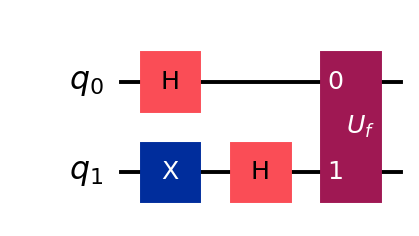

In [34]:
def deutsch_prefix(Uf: QuantumCircuit) -> QuantumCircuit:
    """
    Circuit up to (and including) the oracle Uf.
    No final Hadamard or measurements yet.
    """
    qc = QuantumCircuit(2, name="Deutsch_prefix")

    # Step 1: |0>|1>
    qc.x(1)

    # Step 2: Hadamards to create |+>|->
    qc.h(0)
    qc.h(1)

    # Step 3: apply the oracle as a single box
    qc.append(Uf.to_gate(label=r"$U_f$"), [0, 1])

    return qc

# Example: prefix circuit for the balanced function f2(x) = x
Uf_balanced = deutsch_oracle(2)
display(deutsch_prefix(Uf_balanced).draw("mpl", scale=1.4))


### 3.4 Phase Kickback: The Engine of the Algorithm

We will now analyse the most important part of the algorithm: what happens when we apply the oracle $U_f$ to our special superposition state?

This is where the "quantum trick" happens. We will *not* be computing the answer $f(x)$ into the ancilla. Instead, we will "kick" the answer back into the *phase* of our input qubit.

Our oracle's rule is:
$$
U_f:\;|x\rangle|y\rangle \;\longmapsto\; |x\rangle\,|y\oplus f(x)\rangle
$$
So far, we've only considered the "classical" mode: setting $|y\rangle = |0\rangle$.

Now, let's analyse the "quantum" mode. The state just before the oracle (from section 3.3) is $|\psi_1\rangle = |+\rangle|-\rangle$.

---

#### Step 1: Set Up the Full Input State

First, let's write out our starting state, $|\psi_1\rangle = |+\rangle \otimes |-\rangle$.

* The input qubit (q0) is in state $|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$.
* The ancilla qubit (q1) is in state $|-\rangle$.

We can write the full state as a superposition of our *inputs* ($|0\rangle$ and $|1\rangle$):
$$
|\psi_1\rangle = \left[ \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \right] \otimes |-\rangle
$$
Using linearity (the distributive law), we can expand this:
$$
|\psi_1\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle|-\rangle + |1\rangle|-\rangle \right)
$$

This is the state that enters the oracle $U_f$.

---

#### Step 2: Apply the Oracle $U_f$ to the Superposition

We want to calculate $|\psi_2\rangle = U_f(|\psi_1\rangle)$. We can use linearity again and apply $U_f$ to each term in the superposition:

$$
|\psi_2\rangle = U_f\left( \frac{1}{\sqrt{2}} \left( |0\rangle|-\rangle + |1\rangle|-\rangle \right) \right)
$$
$$
|\psi_2\rangle = \frac{1}{\sqrt{2}} \left( U_f(|0\rangle|-\rangle) + U_f(|1\rangle|-\rangle) \right)
$$
This is great, but now we have two new terms: $U_f(|0\rangle|-\rangle)$ and $U_f(|1\rangle|-\rangle)$. We need to figure out what these are.

Let's derive a general "tool" for what $U_f$ does to *any* input $|x\rangle$ when the ancilla is in the $|-\rangle$ state.

---

#### Step 3: Deriving the "Phase Kickback" Tool

Let's calculate the general term $U_f\bigl(|x\rangle|-\rangle\bigr)$ in full detail.

1.  **Start with the definition:**
    $U_f\bigl(|x\rangle|-\rangle\bigr)$

2.  **Expand the ancilla state $|-\rangle$:**
    $|-\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$.
    $$
    = U_f\left( |x\rangle \otimes \left[ \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) \right] \right)
    $$

3.  **Distribute $|x\rangle$ and $\frac{1}{\sqrt{2}}$ (this is just algebra):**
    $$
    = \frac{1}{\sqrt{2}} \left( U_f(|x\rangle|0\rangle) - U_f(|x\rangle|1\rangle) \right)
    $$

4.  **Apply the oracle rule** $U_f(|x\rangle|y\rangle) = |x\rangle|y \oplus f(x)\rangle$ to *each* term inside:
    $$
    = \frac{1}{\sqrt{2}} \left( |x\rangle|0 \oplus f(x)\rangle - |x\rangle|1 \oplus f(x)\rangle \right)
    $$

5.  **Factor out the input state $|x\rangle$**, which is left unchanged:
    $$
    = |x\rangle \otimes \left[ \frac{1}{\sqrt{2}} \left( |0 \oplus f(x)\rangle - |1 \oplus f(x)\rangle \right) \right]
    $$

This looks complicated, but now we just have to analyse the ancilla part. Remember, $f(x)$ is just a classical bit: its value is **either 0 or 1**.

* **Case 1: What if $f(x) = 0$?**
    The ancilla part becomes:
    $$
    \frac{1}{\sqrt{2}} \left( |0 \oplus 0\rangle - |1 \oplus 0\rangle \right) = \frac{1}{\sqrt{2}} \left( |0\rangle - |1\rangle \right) = |-\rangle
    $$
    So the full state is: $|x\rangle \otimes |-\rangle$. **(It didn't change!)**

* **Case 2: What if $f(x) = 1$?**
    The ancilla part becomes:
    $$
    \frac{1}{\sqrt{2}} \left( |0 \oplus 1\rangle - |1 \oplus 1\rangle \right) = \frac{1}{\sqrt{2}} \left( |1\rangle - |0\rangle \right)
    $$
    This is *almost* $|-\rangle$. Let's factor out a $-1$:
    $$
    = -1 \times \left[ \frac{1}{\sqrt{2}} \left( |0\rangle - |1\rangle \right) \right] = -|-\rangle
    $$
    So the full state is: $-|x\rangle \otimes |-\rangle$. **(It picked up a minus sign!)**

---
#### Step 4: The Final Result (The Phase Oracle)

We can summarise these two cases with a single, powerful formula:

$$
U_f\bigl(|x\rangle|-\rangle\bigr) = (-1)^{f(x)}\,|x\rangle|-\rangle
$$

This is **Phase Kickback**. The information about $f(x)$ was "kicked back" as a phase ($+1$ or $-1$) onto the *input* qubit $|x\rangle$, and the ancilla state $|-\rangle$ was returned unchanged.

Now we can finally solve our equation from Step 2.
We had:
$$
|\psi_2\rangle = \frac{1}{\sqrt{2}} \left( U_f(|0\rangle|-\rangle) + U_f(|1\rangle|-\rangle) \right)
$$
Apply our new Phase Kickback tool to each term:
* $U_f(|0\rangle|-\rangle) = (-1)^{f(0)}|0\rangle|-\rangle$
* $U_f(|1\rangle|-\rangle) = (-1)^{f(1)}|1\rangle|-\rangle$

Substitute these in:
$$
|\psi_2\rangle = \frac{1}{\sqrt{2}} \left( (-1)^{f(0)}|0\rangle|-\rangle + (-1)^{f(1)}|1\rangle|-\rangle \right)
$$

And finally, we can factorise out the unchanged ancilla:
$$
|\psi_2\rangle = \left[ \frac{(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle}{\sqrt{2}} \right] \otimes |-\rangle
$$

**This is the state of the algorithm just after the oracle.** The ancilla is untouched. The input qubit, however, now contains all the information we need to solve the problem, encoded in its relative phase.

Balanced case f2(x)=x:


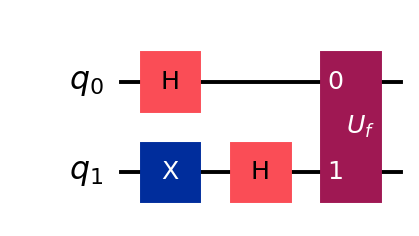

<IPython.core.display.Latex object>


Constant case f1(x)=0:


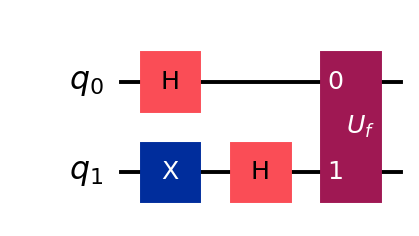

<IPython.core.display.Latex object>

In [35]:
def show_phase_kickback(case: int):
    """
    Build the Deutsch prefix circuit for a chosen oracle f_case,
    then display the statevector right after U_f in LaTeX form.
    """
    Uf = deutsch_oracle(case)
    qc = deutsch_prefix(Uf)

    sv = Statevector.from_instruction(qc)
    display(qc.draw("mpl", scale=1.4))
    display(sv.draw("latex"))

    return sv

# Try with a balanced function f2(x)=x (case=2) and a constant function f1(x)=0 (case=1)
print("Balanced case f2(x)=x:")
sv_bal = show_phase_kickback(2)

print("\nConstant case f1(x)=0:")
sv_const = show_phase_kickback(1)


> **Qubit order reminder (Qiskit little-endian).**
> Qiskit prints basis states as $|q_1 q_0\rangle$.
> In our notation the *top* wire is the input $x$ (q0) and the *bottom* wire is the ancilla (q1).
> So a basis state shown as $|10\rangle$ by Qiskit corresponds to $|x=0\rangle|y=1\rangle$ in our diagrams.

If you look at the LaTeX output for the **balanced** case you should see something equivalent (up to a global phase) to

$$
|\psi_2\rangle
= \frac{1}{\sqrt 2}\bigl(|0\rangle - |1\rangle\bigr)\otimes|-\rangle,
$$

whereas for the **constant** case you obtain

$$
|\psi_2\rangle
= \frac{1}{\sqrt 2}\bigl(|0\rangle + |1\rangle\bigr)\otimes|-\rangle.
$$

The only difference is the **relative phase** between $|0\rangle$ and $|1\rangle$ on the *input* qubit: this is exactly the factor $(-1)^{f(x)}$ that we derived algebraically.

### 3.5 Completing Deutsch’s algorithm (final Hadamard + measurement)

From the previous section we know that, after the oracle, the joint state is

$$
|\psi_2\rangle
= \frac{1}{\sqrt 2}\Big((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle\Big)\otimes|-\rangle.
$$

We now apply a Hadamard to the **top** qubit only:

$$
|\psi_3\rangle = (H\otimes I)\,|\psi_2\rangle.
$$

Using
$$
H|0\rangle = \frac{|0\rangle+|1\rangle}{\sqrt2},\quad
H|1\rangle = \frac{|0\rangle-|1\rangle}{\sqrt2},
$$
one obtains

$$
|\psi_3\rangle
= \frac{1}{2}\Big(
\big((-1)^{f(0)}+(-1)^{f(1)}\big)|0\rangle
+ \big((-1)^{f(0)}-(-1)^{f(1)}\big)|1\rangle
\Big)\otimes|-\rangle.
$$

Now distinguish the two cases:

* If $f$ is **constant**, then $f(0)=f(1)$, so the coefficient of $|1\rangle$ is zero and the top qubit is $|0\rangle$.
* If $f$ is **balanced**, then $f(0)\neq f(1)$, so the coefficient of $|0\rangle$ is zero and the top qubit is $|1\rangle$.

Thus, just before measurement we have

$$
|\psi_3\rangle =
\begin{cases}
|0\rangle|-\rangle & \text{if } f \text{ is constant},\\[2mm]
|1\rangle|-\rangle & \text{if } f \text{ is balanced}.
\end{cases}
$$

Measuring the **top qubit** tells us with probability 1 whether $f$ is constant (outcome 0) or balanced (outcome 1), using **one application** of $U_f$.

Let’s now implement the full circuit and run it on our simulator.

In [ ]:
# 2. Full Deutsch circuit + runner (builds a Gate from the oracle circuit)

def deutsch_circuit(case: int) -> QuantumCircuit:
    """
    Build the full Deutsch circuit for the chosen oracle f_case.

    Output: 2-qubit circuit measuring the *top* qubit (q0) into c0.
    """
    # Turn the oracle circuit into a single boxed oracle gate
    Uf_circ = deutsch_oracle(case)
    Uf_gate = Uf_circ.to_gate(label=r"$U_f$")
    Uf_gate.name = f"Uf_f{case}"

    qc = QuantumCircuit(2, 1, name="Deutsch")

    # TODO:
    #   Implement the 5 steps of Deutsch's algorithm.
    #   1. Prepare |0>|1>.
    #   2. Apply H to both qubits.
    #   3. Apply the oracle U_f (already a Gate).
    #   4. Apply H to the *top* qubit only.
    #   5. Measure the top qubit into classical bit 0.

    ... # FILL IN

    return qc


def run_deutsch(case: int, shots: int = 1024):
    """
    Construct Deutsch’s circuit for the chosen case, run it,
    and print whether f is constant or balanced.
    """
    qc = deutsch_circuit(case)

    # Show the logical circuit with the boxed oracle
    display(qc.draw("mpl", scale=1.4))

    # For Aer: expand the oracle box into its X / CX implementation
    qc_sim = qc.decompose()

    result = sim.run(qc_sim, shots=shots).result()
    counts = result.get_counts()

    print("Measurement counts (top qubit):", counts)

    # TODO:
    #   Decide from the measurement counts whether f is constant or balanced.
    #   Hint: bitstrings are length 1.

    ... # FILL IN

    return counts


# Sanity check: one constant and one balanced function
print("Running Deutsch with constant function f1:")
run_deutsch(1)

print("\nRunning Deutsch with balanced function f2:")
run_deutsch(2)


### 3.6 The Power of Phase Kickback (A Hint for Later)

The crucial identity we have exposed is the **phase-oracle form**:

$$
U_f\bigl(|x\rangle|-\rangle\bigr) = (-1)^{f(x)}\,|x\rangle|-\rangle.
$$

But *why* does this happen? You are correct to suspect there is a deep reason. This phenomenon works because the ancilla state we chose, $|-\rangle$, is a **special state** known as an **eigenstate**.

Let's look at the oracle's action on the ancilla $y$: $|y\rangle \mapsto |y \oplus f(x)\rangle$.
* If $f(x)=0$, the ancilla's operation is $|y \oplus 0\rangle$, which is just an **Identity ($I$)** operation ($I|y\rangle = |y\rangle$).
* If $f(x)=1$, the ancilla's operation is $|y \oplus 1\rangle$, which is a **NOT (Pauli $X$)** operation ($X|y\rangle$).

The state $|-\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$ happens to be a special vector—it is an **eigenstate** of the $X$ operator. Let's check this:
$$
X|-\rangle = X \left( \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right) = \frac{1}{\sqrt{2}} (X|0\rangle - X|1\rangle) = \frac{1}{\sqrt{2}} (|1\rangle - |0\rangle)
$$
If we factor out a $-1$, we get:
$$
= -1 \times \left( \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right) = (-1) \times |-\rangle
$$
So, $X|-\rangle = -1 \times |-\rangle$. The state $|-\rangle$ remains unchanged, but it is multiplied by its **eigenvalue**, $-1$.
(The Identity operation also leaves it unchanged, with an eigenvalue of $+1$).

Because the ancilla is in this special eigenstate, its own state is never altered by the oracle. Instead, the ancilla's eigenvalue, which is $(-1)^{f(x)}$, is "kicked back" as a phase onto the input register. This is the complete mechanism of **phase kickback**.

If we ignore the unchanged ancilla $|-\rangle$, the oracle *behaves* like a new unitary operator that acts *only* on the input register:

$$
Z_f:\;|x\rangle \longmapsto (-1)^{f(x)} |x\rangle
$$

In Deutsch’s algorithm, we used this to learn a *global property* of $f(x)$ (whether $f(0)$ and $f(1)$ were the same) with a single query.

**Hint for the Hackathon:** This is an extremely powerful tool. Imagine you have a large superposition of many input states, $|x\rangle$. You could use a phase oracle to "mark" certain "solution" states by multiplying them by $-1$, while leaving all other states unchanged. A well-designed circuit could then use quantum interference to amplify the probability of measuring precisely those marked states.

So this small example has taught us two key lessons:

1.  The quantum oracle $U_f$ can be turned into a **phase oracle** simply by initialising the ancilla in the state $|-\rangle$ (the eigenstate of the $X$ gate).
2.  Phase information like $(-1)^{f(x)}$ is a powerful resource: it is invisible to classical hardware, but quantum interference allows us to convert this phase into a computational advantage.

---
## 4. From Deutsch to Deutsch–Jozsa

In Deutsch’s algorithm we had a function
$f:\{0,1\}\to\{0,1\}$ and an oracle
$$
U_f:\;|x\rangle|y\rangle \mapsto |x\rangle|y\oplus f(x)\rangle.
$$
By preparing the ancilla in $|-\rangle$ we saw **phase kickback**:
$$
U_f(|x\rangle|-\rangle)=(-1)^{f(x)}|x\rangle|-\rangle.
$$
This gave us a *one-bit* quantum speed-up: one query versus two.

The **Deutsch–Jozsa algorithm** is the natural many-bit version.
Now the function is
$$
f:\{0,1\}^n\to\{0,1\},
$$
and we are promised that $f$ is either

* **constant**: $f(x)=0$ for all $x$, or $f(x)=1$ for all $x$; or
* **balanced**: exactly half of the $2^n$ inputs give 0 and half give 1.

Our task is to output

* 0 if $f$ is constant;
* 1 if $f$ is balanced.

Classically, any deterministic algorithm may need $2^{n-1}+1$ queries in the worst case.
Deutsch–Jozsa solves it with **a single query** using the same phase-kickback trick, just scaled up.

### 4.1 Hadamards on many qubits

For one qubit we already know
$$
H|0\rangle = \frac{|0\rangle+|1\rangle}{\sqrt{2}},\qquad
H|1\rangle = \frac{|0\rangle-|1\rangle}{\sqrt{2}}.
$$
We can write both cases compactly as
$$
H|a\rangle = \frac{1}{\sqrt{2}}\bigl(|0\rangle+(-1)^a|1\rangle\bigr),
\qquad a\in\{0,1\}.
$$

For **$n$ input qubits** we apply a Hadamard to each of them:
$$
H^{\otimes n} = \underbrace{H\otimes H\otimes\cdots\otimes H}_{n\ \text{times}}.
$$

Applied to the all-zero state this gives the uniform superposition
$$
H^{\otimes n}|0\cdots 0\rangle
= \frac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}|x\rangle,
$$
which we have already used in the 3-bit parity example.
This is the “quantum parallelism” part of the algorithm: in a single query, the oracle will be asked about **all** inputs $x$ at once.

### 4.2 Circuit idea for Deutsch–Jozsa

The Deutsch–Jozsa circuit uses $n$ input qubits and one ancilla:

1. Start in $|0\rangle^{\otimes n}|1\rangle$.
2. Apply $H$ to **all** $n+1$ qubits.
   The ancilla becomes $|-\rangle$ and the inputs become the uniform superposition:
   $$
   |-\rangle \otimes \frac{1}{\sqrt{2^n}}\sum_x|x\rangle.
   $$
3. Apply the oracle $U_f$ once.
4. Apply $H^{\otimes n}$ again to the **input** qubits.
5. Measure the input register in the computational basis.

The key step is again **phase kickback**, but now for all bit strings:
$$
U_f\bigl(|x\rangle|-\rangle\bigr)
= (-1)^{f(x)}|x\rangle|-\rangle.
$$
After step 3 the state is therefore
$$
|-\rangle\otimes
\frac{1}{\sqrt{2^n}}\sum_{x}(-1)^{f(x)}|x\rangle.
$$
The ancilla is back in $|-\rangle$ and can be ignored; all the information about $f$ is now stored as **phases** on the input superposition.

### 4.3 Why the measurement distinguishes constant vs balanced

Now apply $H^{\otimes n}$ to the input register.
Using linearity, the amplitude of $|0\cdots 0\rangle$ after the final Hadamards is
$$
\alpha_{0\cdots 0}
=\frac{1}{2^n}\sum_{x\in\{0,1\}^n}(-1)^{f(x)}.
$$

Two cases:

* If $f$ is **constant 0**, then every term is $+1$ and the sum is $2^n$, so $\alpha_{0\cdots 0}=1$.
  The measurement outcome is always $0\cdots 0$.

* If $f$ is **constant 1**, every term is $-1$, the sum is $-2^n$, and again $|\alpha_{0\cdots 0}|^2=1$.
  We still always measure $0\cdots 0$.

* If $f$ is **balanced**, half of the terms are $+1$ and half are $-1$.
  They cancel in the sum, giving $\alpha_{0\cdots 0}=0$.
  Thus the outcome $0\cdots 0$ never occurs.

So with a **single query**:

* if we see $0\cdots 0$ we conclude “$f$ is constant”;
* if we see *any* other bitstring, we conclude “$f$ is balanced”.

Mathematically this is exactly the same mechanism we saw for Deutsch’s algorithm, just applied to the larger register. The phase pattern $(-1)^{f(x)}$ acts like a big **phase oracle**
$$
Z_f:\;|x\rangle \mapsto (-1)^{f(x)}|x\rangle,
$$
implemented using the standard query oracle $U_f$ plus the ancilla in $|-\rangle$.

In [45]:
# 4.4 Qiskit: building constant and balanced oracles for n bits

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

sim = AerSimulator()

def dj_oracle_parity(n: int, kind: str = "balanced") -> QuantumCircuit:
    """
    Simple family of Deutsch–Jozsa oracles on n input bits.

    Qubits (Qiskit little-endian):
      0..n-1 : input register x
      n      : output / ancilla y

    kind:
      "constant_0"  -> f(x) = 0       for all x
      "constant_1"  -> f(x) = 1       for all x
      "balanced"    -> f(x) = parity(x) = x0 ⊕ x1 ⊕ ... ⊕ x_{n-1}

    The oracle acts as
        |x, y>  ->  |x, y ⊕ f(x)>.
    """
    qc = QuantumCircuit(n + 1, name=f"Uf_{kind}")

    if kind == "constant_0":
        # f(x) = 0  → do nothing, y stays as it was
        pass

    elif kind == "constant_1":
        # Flip y regardless of x.
        qc.x(n)

    elif kind == "balanced":
        # Parity: toggle y once for each input qubit that is 1.
        for i in range(n):
            qc.cx(i, n)
    else:
        raise ValueError("kind must be 'constant_0', 'constant_1', or 'balanced'")

    return qc


In [46]:
# 4.5 Deutsch–Jozsa circuit for a given oracle Uf

def dj_circuit(Uf: QuantumCircuit) -> QuantumCircuit:
    """
    Construct the Deutsch–Jozsa circuit for a given (n+1)-qubit oracle Uf.

    Uf is assumed to act on qubits 0..n (inputs + output) as
        |x, y> -> |x, y ⊕ f(x)>.
    We follow the standard DJ layout:
        |0...0>|1>  --H^{⊗(n+1)}-->  |-> sum_x |x> / sqrt(2^n)
        --Uf-->                    |-> sum_x (-1)^{f(x)} |x> / sqrt(2^n)
        --H^{⊗n} on inputs-->      measure inputs.
    """
    n_plus_1 = Uf.num_qubits
    n = n_plus_1 - 1

    qc = QuantumCircuit(n_plus_1, n, name="Deutsch–Jozsa")

    # 1. Initialise |0...0>|1>
    qc.x(n)  # output qubit

    # 2. Apply Hadamard to all qubits (inputs + output)
    qc.h(range(n_plus_1))

    # 3. Apply the oracle Uf as a single boxed gate
    Uf_gate = Uf.to_gate(label=r"$U_f$")
    qc.append(Uf_gate, range(n_plus_1))

    # 4. Apply H to the input register only
    qc.h(range(n))

    # 5. Measure the input register
    qc.measure(range(n), range(n))

    return qc


Deutsch–Jozsa with n=3, function kind='constant_0':


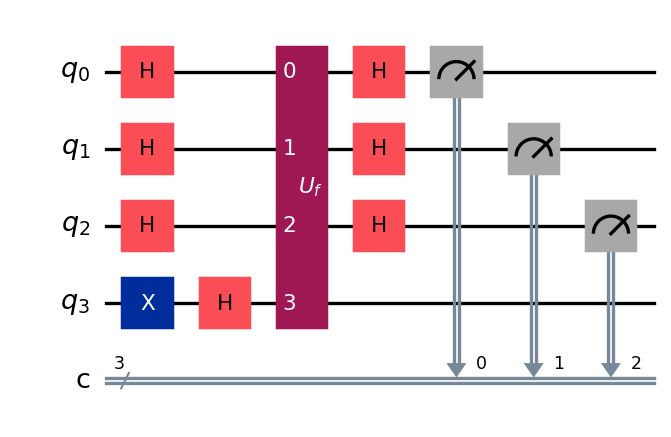

Measurement counts (input register): {'000': 1024}
Algorithm concludes: f is CONSTANT.
Deutsch–Jozsa with n=3, function kind='balanced':


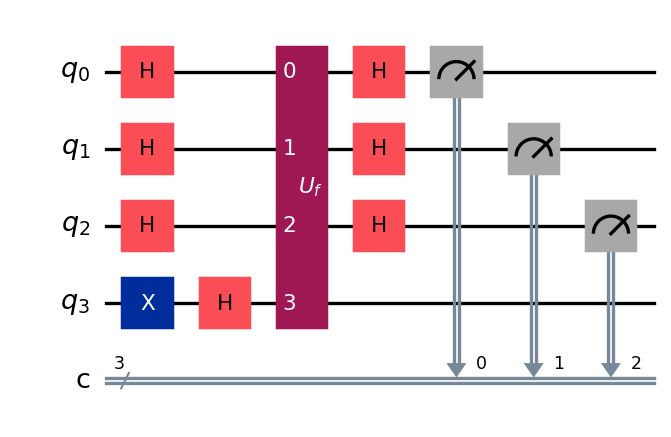

Measurement counts (input register): {'111': 1024}
Algorithm concludes: f is BALANCED.


In [42]:
def run_dj(n: int, kind: str, shots: int = 1024):
    """
    Helper to build a constant or balanced oracle on n inputs,
    run the Deutsch–Jozsa algorithm once, and print the outcome.
    """
    Uf = dj_oracle_parity(n, kind=kind)
    qc = dj_circuit(Uf)

    print(f"Deutsch–Jozsa with n={n}, function kind='{kind}':")
    # Logical circuit with the boxed oracle
    display(qc.draw("mpl", scale=1.2))

    # IMPORTANT: for Aer, expand the custom oracle gate into X / CX
    qc_sim = qc.decompose(reps=2)   # reps=2 is safe if you ever nest gates

    result = sim.run(qc_sim, shots=shots).result()
    counts = result.get_counts()

    print("Measurement counts (input register):", counts)

    # In the ideal DJ algorithm we look for '0...0'
    zero_string = "0" * n
    if counts.get(zero_string, 0) == shots:
        print("Algorithm concludes: f is CONSTANT.")
    else:
        print("Algorithm concludes: f is BALANCED.")

    return counts

# Example runs: constant and balanced
run_dj(3, "constant_0");
run_dj(3, "balanced");

### 4.7 From query oracles to *phase* oracles $Z_f$

For more advanced problems we often want
a **pure phase oracle**
$$
Z_f:\;|x\rangle \mapsto (-1)^{f(x)}|x\rangle
$$
that acts only on the input register.

We have already seen the mechanism:
if we feed an oracle $U_f$ with the ancilla in $|-\rangle$,
$$
U_f\bigl(|x\rangle|-\rangle\bigr)=(-1)^{f(x)}|x\rangle|-\rangle.
$$
The ancilla comes back to $|-\rangle$, while the $|x\rangle$ component picks up a phase $(-1)^{f(x)}$.
In circuit diagrams this whole gadget is drawn as a **single big box** labelled $Z_f$.

In Qiskit we can literally build such a gadget by
preparing the last qubit in $|-\rangle$, applying $U_f$,
and then *unpreparing* the ancilla. The resulting circuit behaves like a phase oracle on the input bits.

In [43]:
# 4.8 Building a phase oracle Z_f from a standard query oracle U_f

def phase_oracle_from_query(Uf: QuantumCircuit) -> QuantumCircuit:
    """
    Given an (n+1)-qubit query oracle Uf implementing
        |x, y> -> |x, y ⊕ f(x)>,
    build a circuit that realises the phase oracle

        Z_f : |x> -> (-1)^{f(x)} |x>

    using the phase kickback trick with the (n-th) ancilla qubit.
    The ancilla is prepared in |-> and returned to |-> afterwards.
    """
    n_plus_1 = Uf.num_qubits
    anc = n_plus_1 - 1

    qc = QuantumCircuit(n_plus_1, name="Z_f_from_Uf")

    # Prepare ancilla in |-> from |0>:  X |0> = |1>, then H|1> = |->.
    qc.x(anc)
    qc.h(anc)

    # Apply the query oracle
    Uf_gate = Uf.to_gate(label=r"$U_f$")
    qc.append(Uf_gate, range(n_plus_1))

    # Unprepare ancilla: H then X (inverse of what we did)
    qc.h(anc)
    qc.x(anc)

    return qc


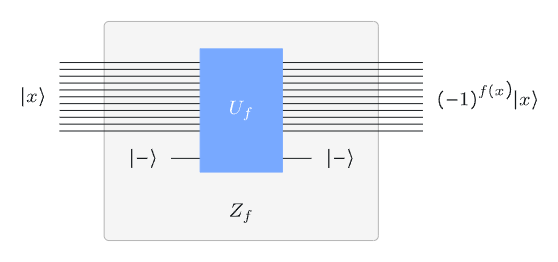

The circuit shown here is a key "trick" in quantum algorithms. It shows how a standard query oracle $U_f$ (which computes an answer) can be turned into a **phase oracle** $Z_f$ (which "marks" an answer with a negative phase) by setting the ancilla qubit to the $|-\rangle$ state.

Image taken from: [1]

In [44]:
# 4.9 Checking the phase oracle on the parity example

from qiskit.quantum_info import Statevector

def show_phase_oracle_effect(n: int = 3):
    """
    Visual check: build Z_f for the balanced parity function,
    apply it to a uniform superposition over inputs, and draw the state.
    """
    # Use the same balanced oracle as before (parity)
    Uf = dj_oracle_parity(n, kind="balanced")
    Zf = phase_oracle_from_query(Uf)

    # Circuit: put inputs in uniform superposition, ancilla left at |0>
    qc = QuantumCircuit(n + 1)
    qc.h(range(n))          # |+...+> on inputs, ancilla remains |0>
    qc.append(Zf.to_gate(label=r"$Z_f$"), range(n + 1))

    sv = Statevector.from_instruction(qc)
    display(sv.draw("latex"))

show_phase_oracle_effect(3)


<IPython.core.display.Latex object>

In the LaTeX statevector you should see the amplitudes of the basis states
$|x\rangle|0\rangle$ acquiring a sign $(-1)^{f(x)}$.
For the parity function this means all bitstrings of **odd** Hamming weight
have a minus sign. This is exactly the **large phase oracle** $Z_f$ that we
will later plug into Grover’s algorithm.

Conceptually:

* **Deutsch** showed phase kickback for a 1-bit function.
* **Deutsch–Jozsa** uses the same phenomenon on $n$ bits to separate
  constant from balanced functions in a single query.
* **Grover** and many other algorithms package this into a reusable gate
  $Z_f$ that flips the phase of the “marked” states.

You now have both the **maths** and the **Qiskit pattern** for building these
big phase oracles, which you can adapt and extend in the hackathon.

---
#### Bonus exercise – Build your own phase oracles

In this section we have seen how to turn a “compute” oracle $U_f$ with an ancilla into a pure **phase oracle** $Z_f$ acting only on the input register.

Let’s practice this in two small steps.

---

**Bonus 4.7.A – A custom phase oracle $Z_f$ on 4–5 qubits**

Pick a simple Boolean function
$$
f:\{0,1\}^n \to \{0,1\}
$$
on $n=4$ (or $n=5$) bits. For example, you could mark one or two specific bit strings such as
$$
f(x) = 1 \text{ iff } x \in \{1010,\,0110\},
$$
and $f(x)=0$ otherwise.

1.  **Build a standard query oracle $U_f$.**
    Implement a circuit on $n+1$ qubits that performs
    $$
    U_f: |x\rangle|y\rangle \mapsto |x\rangle|y \oplus f(x)\rangle.
    $$
    In Qiskit, create a `QuantumCircuit(n+1)` and use multi-controlled $X$ gates (and `X` pre/post on controls if needed) so that the last qubit flips exactly on the marked basis states.

2.  **Turn it into a phase oracle $Z_f$.**
    Using the mechanism from above, construct a new circuit that:
    * prepares the last qubit in $|-\rangle = (|0\rangle - |1\rangle)/\sqrt{2}$,
    * calls your oracle $U_f$,
    * and then unprepares the ancilla (brings it back to $|0\rangle$).

    The overall action on the first $n$ qubits should be
    $$
    |x\rangle \longmapsto (-1)^{f(x)} |x\rangle.
    $$

    *Hint:* you can either (i) literally do “prepare $|-\rangle$ → apply $U_f$ → undo the $|-\rangle$ preparation” in a single bigger circuit, or (ii) wrap this gadget into a `Gate`/`Instruction` called `Z_f`.

3.  **Check that it works.**
    * Initialize the input register in $|x\rangle$ for a few basis states and use the statevector simulator to verify that the only change is a global sign $(-1)^{f(x)}$.
    * Then try a superposition, e.g. $H^{\otimes n}|0^n\rangle$, and confirm that amplitudes corresponding to “marked” strings pick up a minus sign.

---


In [73]:
def uf_from_marked(n: int, marked_bitstrings):
    """
    Build a (n+1)-qubit oracle Uf such that
        Uf |x, y> = |x, y ⊕ f(x)>
    where f(x)=1 iff x is in 'marked_bitstrings'.

    Qubits (Qiskit little-endian):
      0..n-1 : input bits x0, x1, ...
      n      : ancilla / output y
    """
    qc = QuantumCircuit(n + 1, name="Uf_marked")

    # TODO (students):
    #   For each classical pattern in 'marked_bitstrings' (e.g. "1010"):
    #     1. Check that its length is n.
    #     2. Decide which qubits should be "0" in that pattern.
    #     3. Temporarily flip those "0"-qubits with X so that
    #        the pattern "looks like" all-ones to the multi-controlled X.
    #     4. Apply a multi-controlled X (mcx) from all input qubits
    #        to the ancilla.
    #     5. Undo the temporary X flips.

    ... # FILL IN

    return qc


In [74]:
def zf_gadget_from_marked(n: int, marked_bitstrings):
    """
    Build a (n+1)-qubit circuit that implements a phase oracle via kickback:

        |x>|0>  →  (-1)^{f(x)} |x>|0>

    by:
      * preparing ancilla in |->,
      * applying Uf,
      * un-preparing ancilla back to |0>.

    Here, f(x)=1 iff x is in 'marked_bitstrings'.
    """
    # TODO (students):
    #   1. Use uf_from_marked(...) to get the (n+1)-qubit query oracle Uf.
    #   2. Convert Uf into a Gate with a nice LaTeX label "$U_f$".
    #   3. Create a new (n+1)-qubit circuit 'qc'.
    #   4. Prepare the ancilla qubit (index n) in |->
    #        |0> --X--> |1> --H--> |->
    #   5. Append the Uf gate on all qubits.
    #   6. Unprepare the ancilla back to |0>:
    #        |->
    #          --H--> |1>
    #          --X--> |0>

    ... # FILL IN

    return Uf, qc

In [ ]:
n = 4
marked = ["1010", "0010"]

Uf, Zf_gadget = zf_gadget_from_marked(n, marked)

print("Oracle Uf (compute version):")
display(Uf.draw("mpl", scale=1.2))

print("Phase-gadget circuit (implements Z_f via phase kickback):")
display(Zf_gadget.draw("mpl", scale=1.2))


In [ ]:
# Prepare |+...+> on inputs and |0> on ancilla, then apply Z_f gadget
qc_test = QuantumCircuit(n + 1, name="Zf_on_superposition")
qc_test.h(range(n))  # H^{⊗ n} on inputs
qc_test.append(Zf_gadget.to_gate(label=r"$Z_f$"), range(n + 1))

sv = Statevector.from_instruction(qc_test)
display(sv.draw("latex"))

---

**Bonus 4.7.B – The $n$-bit OR phase oracle $Z_{\text{OR}}$**

Define the $n$-bit OR function by
$$
\mathrm{OR}(x) =
\begin{cases}
0 & \text{if } x = 0^n,\\
1 & \text{if } x \neq 0^n.
\end{cases}
$$

The corresponding phase oracle acts on computational basis states as
$$
Z_{\text{OR}}|x\rangle =
\begin{cases}
\ \ |x\rangle & \text{if } x = 0^n,\\
-\,|x\rangle & \text{if } x \neq 0^n.
\end{cases}
$$

1.  **Design a circuit for $Z_{\text{OR}}$ on $n=4$ (and, if you want, $n=5$) qubits.**
    Your circuit should act only on the input register, with no ancilla at the end.

    *Hints (you don’t need to use all of them):*
    * Up to an *overall* global phase, $Z_{\text{OR}}$ is equivalent to “flip the phase of $|0^n\rangle$ and do nothing on all other basis states”.
    * You can map $|0^n\rangle$ to $|1^n\rangle$ with $X$ gates on all qubits, apply an $n$-controlled $Z$, and then undo the $X$ gates.
    * In Qiskit, an $n$-controlled $Z$ can be implemented via the `h`–`mcx`–`h` trick on the last qubit:
      1. `h` on the last qubit,
      2. `mcx` with the other $n-1$ qubits as controls,
      3. `h` on the last qubit again.

2.  **Test your $Z_{\text{OR}}$.**
    * Run the circuit on all computational basis states $|x\rangle$ for $x \in \{0,1\}^n$ using the statevector simulator and verify the correct sign pattern.
    * As a sanity check, apply $Z_{\text{OR}}$ to the uniform superposition $H^{\otimes n}|0^n\rangle$ and inspect which amplitudes change sign.

(These are optional “bonus” tasks. They’re a good way to get comfortable building non-trivial oracles and debugging them with the simulator.)

In [77]:
def zor_phase_oracle(n: int) -> QuantumCircuit:
    r"""
    n-qubit phase oracle Z_OR such that

        Z_OR |0^n> = |0^n>
        Z_OR |x>   = -|x>   for any x != 0^n.

    This matches the IBM definition Z_OR |x> = (-1)^{\mathrm{OR}(x)} |x>.
    """
    qc = QuantumCircuit(n, name="Z_OR")

    # TODO (students):
    #   Implement a unitary whose diagonal is
    #       (1, -1, -1, ..., -1)
    #   i.e. a phase flip on all states except |0^n>.
    #
    #   One convenient way:
    #     1. Build a phase flip on |0^n> (only) using:
    #          * X on all qubits to map |0^n> <-> |1^n>
    #          * a multi-controlled Z on |1^n>
    #          * X on all qubits again.
    #     2. Multiply the whole unitary by a global phase of -1
    #        so that the diagonal becomes (1, -1, ..., -1).
    #        hint: use qc.global_phase = ___

    ... # FILL IN

    return qc


In [ ]:
n = 4
Z_or = zor_phase_oracle(n)

print("Z_OR phase oracle circuit:")
display(Z_or.draw("mpl", scale=1.2))

# TODO (students):
#   1. Prepare the basis state |0000> and apply Z_or.
#      Inspect the statevector and confirm that it is unchanged.
#   2. Prepare the basis state |0001> and apply Z_or.
#      Inspect the statevector and confirm that it picks up a minus sign.
#
#   Skeleton:
#     qc_zero = QuantumCircuit(n)
#     qc_zero.compose(Z_or, inplace=True)
#     sv_zero = 
#
#     qc_one = QuantumCircuit(n)
#     qc_one.x(0)
#     qc_one.compose(Z_or, inplace=True)
#     sv_one = 

... # FILL IN

In [ ]:
qc_super = QuantumCircuit(n, name="Z_OR_on_superposition")
qc_super.h(range(n))  # |+...+> = 1/√(2^n) sum_x |x>
qc_super.append(Z_or.to_gate(label=r"$Z_{\mathrm{OR}}$"), range(n))

sv_super = Statevector.from_instruction(qc_super)
display(sv_super.draw("latex"))

---
## References IEEE

[1] "Grover's Algorithm Description," *Fundamentals of Quantum Algorithms*, IBM Quantum. [Online]. Available: https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/grover-algorithm/grover-algorithm-description

[2] "Simulating Classical Computations," *Fundamentals of Quantum Algorithms*, IBM Quantum. [Online]. Available: https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/quantum-algorithmic-foundations/simulating-classical-computations

[3] "Deutsch's Algorithm," *Fundamentals of Quantum Algorithms*, IBM Quantum. [Online]. Available: https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/deutsch-algorithm